Instalação e Importação de Bibliotecas
Precisamos da biblioteca networkx, que é o padrão para análise de redes em Python.

In [1]:
# Célula 1: Instalação e Importação
!pip install networkx

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# Configurações de visualização
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (15, 15)

print("Bibliotecas prontas para a análise de redes.")

   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ------------------------------ --------- 1.6/2.0 MB 10.3 MB/s eta 0:00:01
   ---------------------------------------- 2.0/2.0 MB 9.8 MB/s eta 0:00:00
Bibliotecas prontas para a análise de redes.


Carregando e Preparando os Dados
Para esta análise, precisamos apenas do fluxo de bolsistas do arquivo do CNPq.

In [2]:
# Célula 2: Carregando e Preparando os Dados
path_cnpq = '../data/raw/Relatorio_de_dados_abertos_CNPq.csv'

# Carregando os dados novamente, com as mesmas correções de antes
dtype_cnpq = {0: 'str', 7: 'str', 23: 'str', 24: 'str'}
df_cnpq = pd.read_csv(path_cnpq, sep=';', encoding='latin-1', skiprows=5, dtype=dtype_cnpq)

# Selecionando as colunas de origem e destino e removemos linhas onde uma delas é nula
df_fluxo = df_cnpq[['Instituição Origem', 'Instituição Destino']].dropna().copy()

# Removendo casos onde a origem e o destino são a mesma instituição
df_fluxo = df_fluxo[df_fluxo['Instituição Origem'] != df_fluxo['Instituição Destino']]

# Contar quantas vezes cada fluxo (origem -> destino) acontece.
# Isso será o "peso" da nossa conexão.
df_fluxo_agregado = df_fluxo.groupby(['Instituição Origem', 'Instituição Destino']).size().reset_index(name='peso')

print(f"Encontramos {len(df_fluxo_agregado)} fluxos únicos de pesquisadores entre instituições.")
df_fluxo_agregado.sort_values(by='peso', ascending=False).head(10)

Encontramos 905 fluxos únicos de pesquisadores entre instituições.


,Instituição Origem,Instituição Destino,peso
432,Universidade Federal de Minas Gerais,Faculdade de Filosofia e Ciências Humanas,28
263,Universidade Católica de Brasília,Universidade Católica Dom Bosco,26
687,Universidade Federal do Rio Grande do Sul,Hospital de Clínicas de Porto Alegre,24
48,Empresa Brasileira de Pesquisa Agropecuária,Centro Nacional de Pesquisa de Soja,18
722,Universidade Federal do Rio de Janeiro,Grupo Águas do Brasil,16
36,Cornell University,Bussola Consultoria Desenvolvimento Eireli,16
429,Universidade Federal de Minas Gerais,Centro de Pesquisas René Rachou,14
202,Instituto de Pesquisas Tecnológicas do Estado ...,Universidade de São Paulo,13
192,Instituto Universitário de Pesquisas do Rio de...,Instituto de Estudos Sociais e Políticos,13
258,UFPR,IFSP - Campus Matão,13


Construindo o Grafo da Rede
Usamos o networkx para transformar nossa tabela de fluxos em um objeto de rede (um grafo direcionado).

In [3]:
# Célula 3: Construindo o Grafo da Rede
# Criamos um grafo direcionado (DiGraph), pois o fluxo tem uma direção (origem -> destino)
G = nx.from_pandas_edgelist(
    df_fluxo_agregado,
    source='Instituição Origem',
    target='Instituição Destino',
    edge_attr='peso', # O peso da aresta será o número de bolsistas nesse fluxo
    create_using=nx.DiGraph()
)

print(f"Grafo criado com sucesso!")
print(f"Número de instituições (nós): {G.number_of_nodes()}")
print(f"Número de conexões (arestas): {G.number_of_edges()}")

Grafo criado com sucesso!
Número de instituições (nós): 806
Número de conexões (arestas): 905


Análise de Centralidade (Identificando os Hubs)
Vamos calcular algumas métricas para descobrir quais são as instituições mais importantes na rede.

In [4]:
# Célula 4: Análise de Centralidade

# 1. In-Degree: Quais instituições mais RECEBEM pesquisadores? (Os maiores hubs)
in_degree = dict(G.in_degree(weight='peso'))
df_in_degree = pd.DataFrame(list(in_degree.items()), columns=['Instituição', 'Total de Pesquisadores Recebidos'])
df_in_degree = df_in_degree.sort_values(by='Total de Pesquisadores Recebidos', ascending=False)
print("--- Top 10 Instituições que Mais Recebem Pesquisadores (Hubs) ---")
print(df_in_degree.head(10))

# 2. Out-Degree: Quais instituições mais ENVIAM pesquisadores para outras? (As "formadoras")
out_degree = dict(G.out_degree(weight='peso'))
df_out_degree = pd.DataFrame(list(out_degree.items()), columns=['Instituição', 'Total de Pesquisadores Enviados'])
df_out_degree = df_out_degree.sort_values(by='Total de Pesquisadores Enviados', ascending=False)
print("\n--- Top 10 Instituições que Mais Enviam Pesquisadores ---")
print(df_out_degree.head(10))

--- Top 10 Instituições que Mais Recebem Pesquisadores (Hubs) ---
                                    Instituição  \
500   Faculdade de Filosofia e Ciências Humanas   
210             Universidade Católica Dom Bosco   
675        Hospital de Clínicas de Porto Alegre   
281                   Universidade de São Paulo   
30             Centro de Pesquisas René  Rachou   
1                  Universidade Federal do Pará   
83          Centro Nacional de Pesquisa de Soja   
274                      Universidade de Lisboa   
694                       Grupo Águas do Brasil   
62   Bussola Consultoria Desenvolvimento Eireli   

     Total de Pesquisadores Recebidos  
500                                28  
210                                27  
675                                24  
281                                22  
30                                 21  
1                                  19  
83                                 18  
274                                17  
694         

Visualização da Rede
Visualizar uma rede com milhares de nós é impossível (vira um "emaranhado de fios"). A melhor abordagem é visualizar um subgrafo com os nós mais importantes.

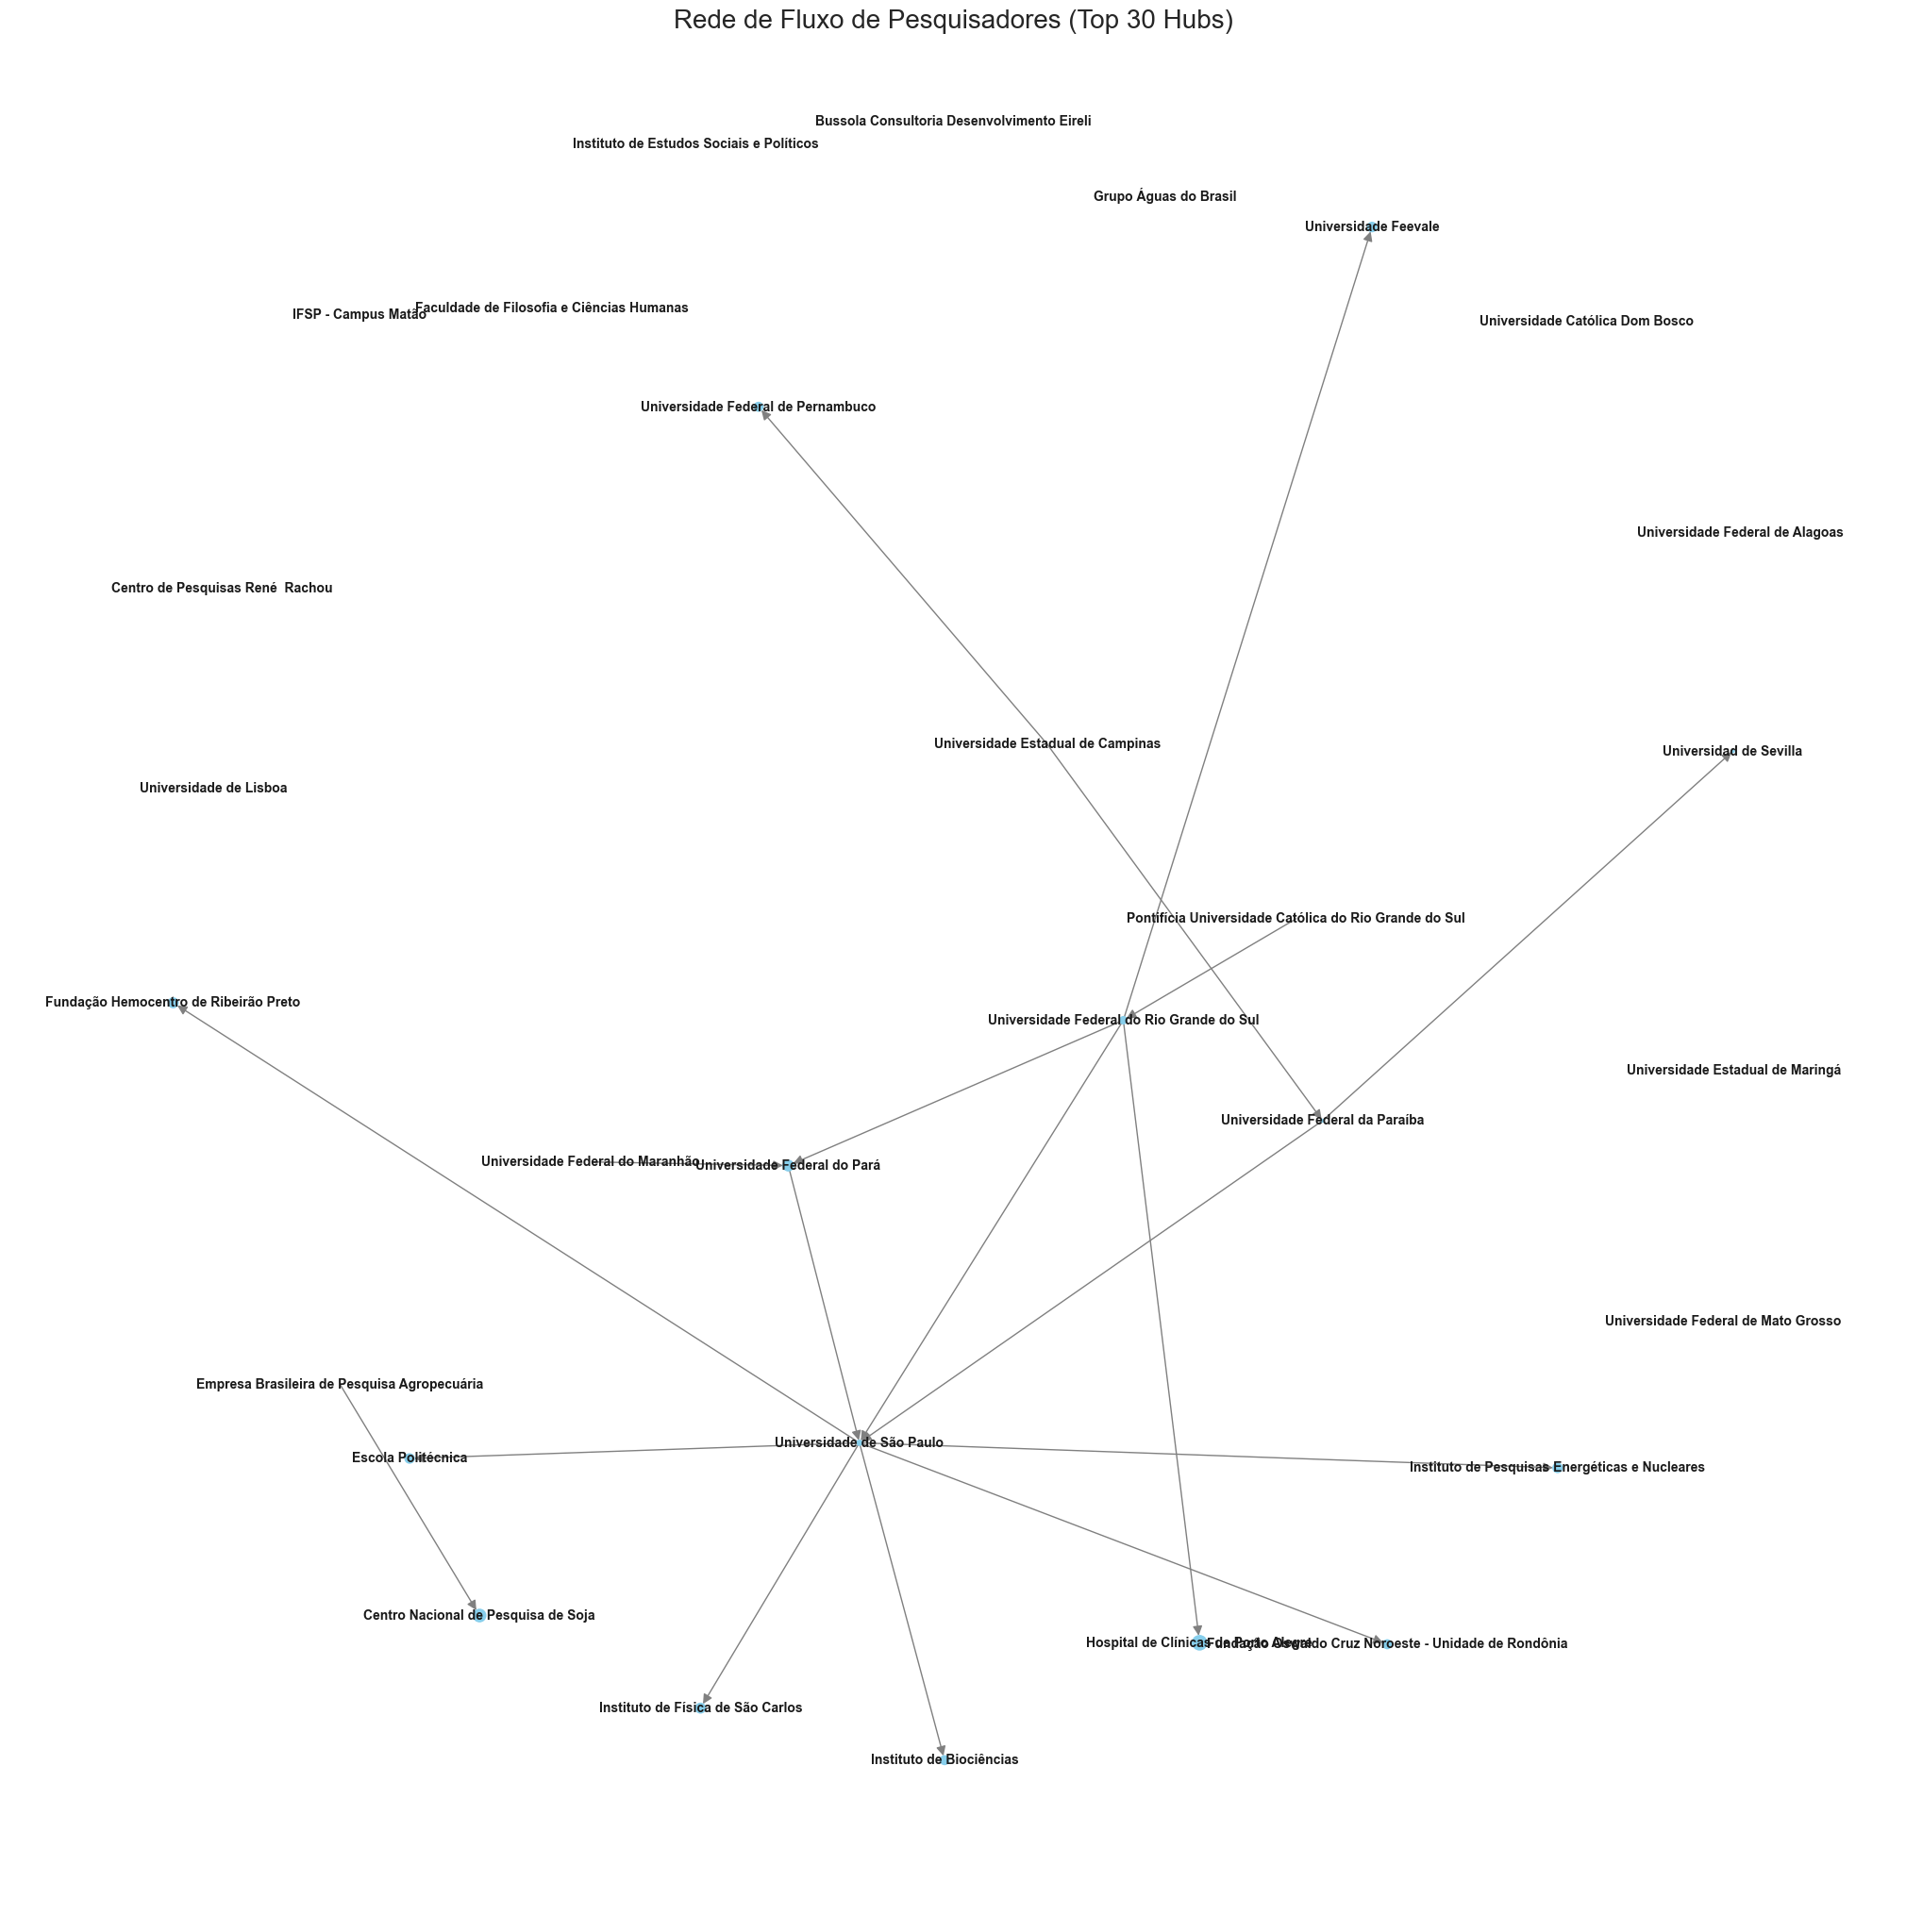

In [5]:
# Célula 5: Visualização da Rede
# Vamos pegar as 30 instituições com mais conexões de entrada (in-degree) para a visualização
top_nodes = df_in_degree['Instituição'].head(30).tolist()
subgraph = G.subgraph(top_nodes)

# Calcula as posições dos nós para um layout mais agradável
pos = nx.spring_layout(subgraph, k=0.5, iterations=50, seed=42)

# Define o tamanho dos nós com base no número de pesquisadores que eles recebem
node_sizes = [v * 5 for v in dict(subgraph.in_degree(weight='peso')).values()]

plt.figure(figsize=(20, 20))
nx.draw(
    subgraph,
    pos,
    with_labels=True,
    node_size=node_sizes,
    node_color='skyblue',
    edge_color='gray',
    font_size=10,
    font_weight='bold',
    arrowsize=15
)
plt.title('Rede de Fluxo de Pesquisadores (Top 30 Hubs)', size=20)
plt.show()